This contains the implementations for the models: Efficientnet, Mobilenet, VGG, Resnet50 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

2024-04-17 23:21:21.427575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 23:21:21.427679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 23:21:21.564149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_dir =  "dataset/cifake/"
print(dataset_dir)

Loading dataset from: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
img_height = 32
img_width = 32
batch_size = 512

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


In [6]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 

# ResNet50

In [29]:
# Building the Transfer Learning model using ResNet50
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
ResNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = ResNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
ResNet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 256)               524544    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                16448

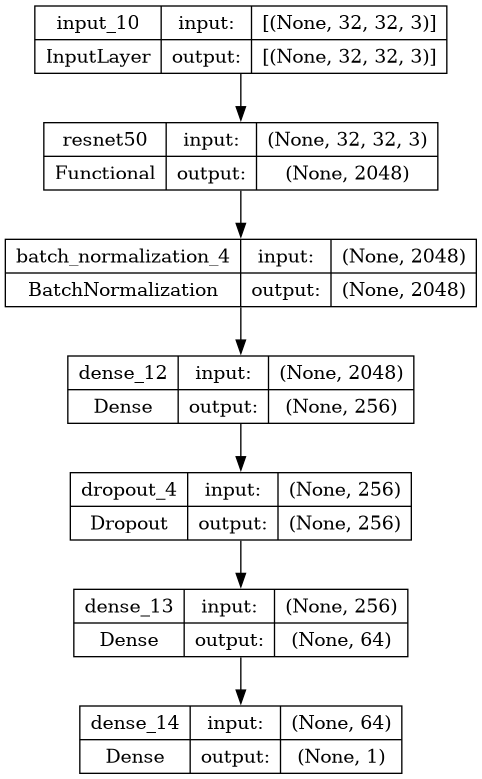

In [30]:
# Visualize the ResNet model architecture
tf.keras.utils.plot_model(ResNet_model, show_shapes = True, to_file = 'ResNet_model.png')
Image('ResNet_model.png') 

In [31]:
# Train the Transfer Learning model
print("Starting training with Transfer Learning using ResNet50...")
ResNet_model_history = ResNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 25,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using ResNet50...
Epoch 1/25
196/196 [==============================] - 75s 181ms/step - loss: 1.4876 - accuracy: 0.9146 - precision_4: 0.9142 - recall_4: 0.9152 - val_loss: 0.6925 - val_accuracy: 0.8471 - val_precision_4: 0.9898 - val_recall_4: 0.7013
Epoch 2/25
196/196 [==============================] - 31s 153ms/step - loss: 0.3046 - accuracy: 0.9488 - precision_4: 0.9496 - recall_4: 0.9480 - val_loss: 0.2881 - val_accuracy: 0.9342 - val_precision_4: 0.9044 - val_recall_4: 0.9710
Epoch 3/25
196/196 [==============================] - 31s 153ms/step - loss: 0.1776 - accuracy: 0.9584 - precision_4: 0.9595 - recall_4: 0.9571 - val_loss: 0.1747 - val_accuracy: 0.9523 - val_precision_4: 0.9468 - val_recall_4: 0.9584
Epoch 4/25
196/196 [==============================] - 31s 153ms/step - loss: 0.1334 - accuracy: 0.9679 - precision_4: 0.9694 - recall_4: 0.9662 - val_loss: 0.2476 - val_accuracy: 0.9229 - val_precision_4: 0.9867 - val_recall_4: 0.8574
E

In [32]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = ResNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 93ms/step - loss: 0.1262 - accuracy: 0.9604 - precision_4: 0.9515 - recall_4: 0.9702
Val Loss: 0.1262
Val Accuracy: 0.9604
Val Precision: 0.9515
Val Recall: 0.9702


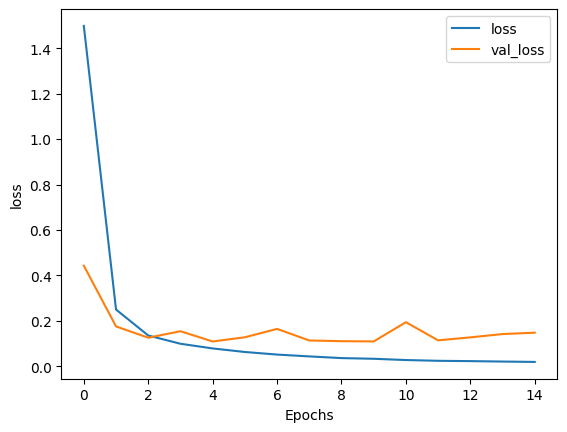

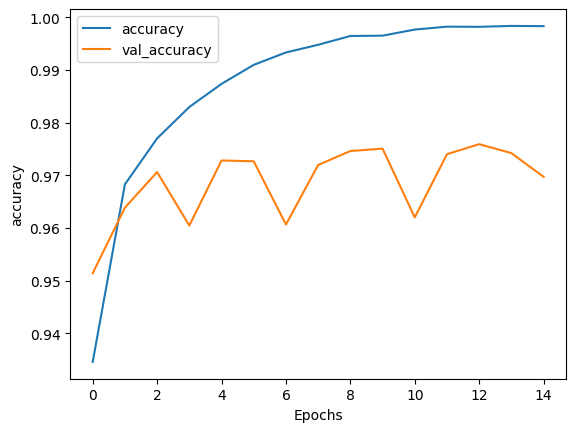

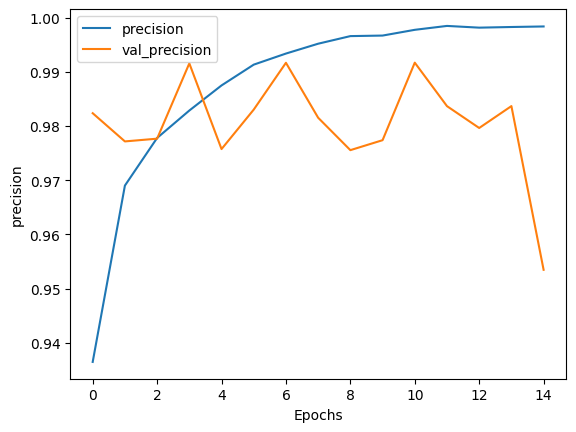

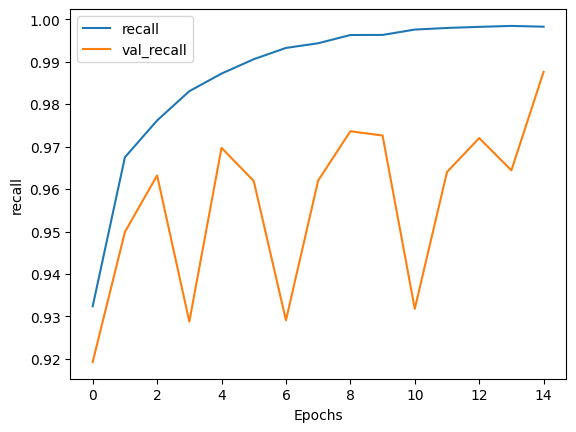

In [11]:
# Plot error rates and metric rates
plot_metrics(ResNet_model_history, 'loss')
plot_metrics(ResNet_model_history, 'accuracy')
plot_metrics(ResNet_model_history, 'precision')
plot_metrics(ResNet_model_history, 'recall')

# VGG

In [12]:
# Building the Transfer Learning model using VGG16
VGG_base_model = tf.keras.applications.VGG16(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
VGG_base_model.trainable = True

# Create a new model on top of the VGG16 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = VGG_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
VGG_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
VGG_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
VGG_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448

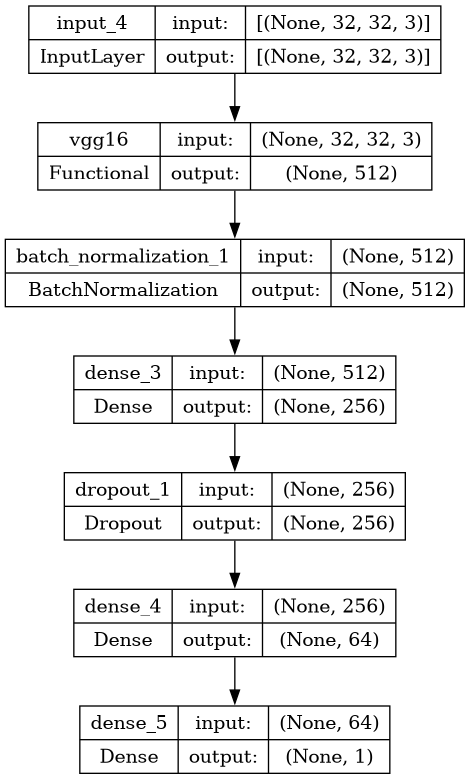

In [13]:
# Visualize the VGG model architecture
tf.keras.utils.plot_model(VGG_model, show_shapes = True, to_file = 'VGG_model.png')
Image('VGG_model.png')

In [14]:
print("Starting training with Transfer Learning using VGG16...")
VGG_model_history = VGG_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using VGG16...
Epoch 1/100
196/196 [==============================] - 43s 148ms/step - loss: 1.5213 - accuracy: 0.7746 - precision_1: 0.7585 - recall_1: 0.8058 - val_loss: 1.0254 - val_accuracy: 0.6705 - val_precision_1: 0.6032 - val_recall_1: 0.9968
Epoch 2/100
196/196 [==============================] - 28s 140ms/step - loss: 0.4066 - accuracy: 0.9116 - precision_1: 0.9064 - recall_1: 0.9181 - val_loss: 0.4138 - val_accuracy: 0.8622 - val_precision_1: 0.7939 - val_recall_1: 0.9785
Epoch 3/100
196/196 [==============================] - 26s 129ms/step - loss: 0.2569 - accuracy: 0.9314 - precision_1: 0.9309 - recall_1: 0.9319 - val_loss: 0.2499 - val_accuracy: 0.9244 - val_precision_1: 0.8968 - val_recall_1: 0.9591
Epoch 4/100
196/196 [==============================] - 28s 136ms/step - loss: 0.1999 - accuracy: 0.9436 - precision_1: 0.9454 - recall_1: 0.9417 - val_loss: 0.2242 - val_accuracy: 0.9272 - val_precision_1: 0.9691 - val_recall_1: 0.8824


In [15]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = VGG_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 89ms/step - loss: 0.1430 - accuracy: 0.9603 - precision_1: 0.9715 - recall_1: 0.9485
Val Loss: 0.1430
Val Accuracy: 0.9603
Val Precision: 0.9715
Val Recall: 0.9485


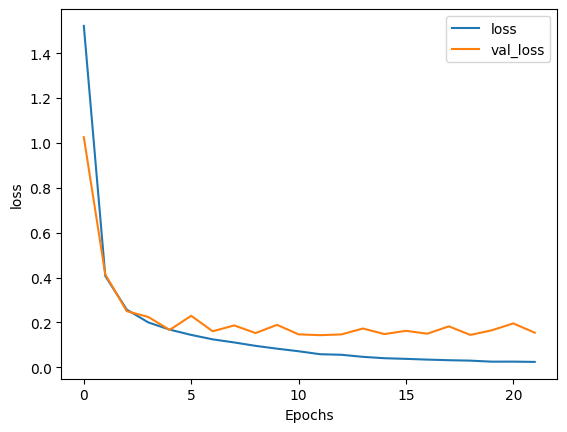

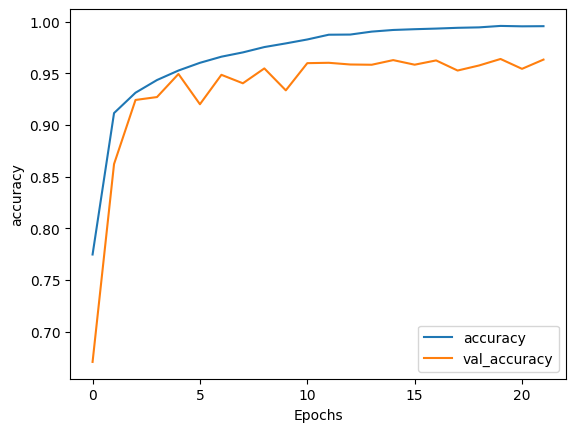

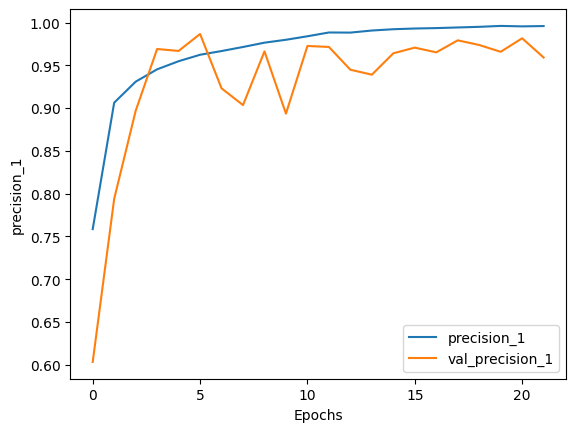

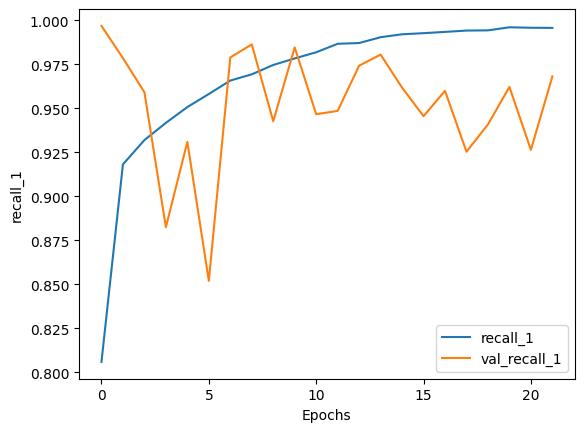

In [16]:
# Plot error rates and metric rates
plot_metrics(VGG_model_history, 'loss')
plot_metrics(VGG_model_history, 'accuracy')
plot_metrics(VGG_model_history, 'precision_1')
plot_metrics(VGG_model_history, 'recall_1')

# EfficientNetV2B0

In [17]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                1644

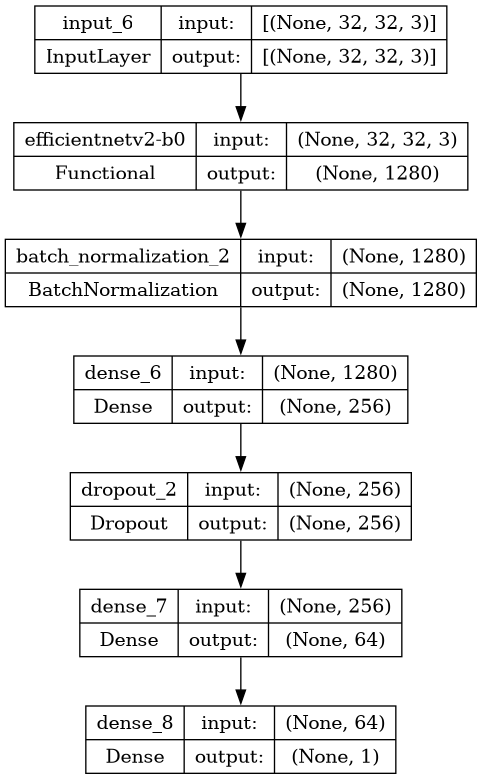

In [18]:
# Visualize the EfficientNet model architecture
tf.keras.utils.plot_model(EfficientNet_model, show_shapes = True, to_file = 'EfficientNet_model.png')
Image('EfficientNet_model.png')

In [19]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using EfficientNet...")
EfficientNet_model_history = EfficientNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using EfficientNet...
Epoch 1/100
196/196 [==============================] - 93s 270ms/step - loss: 1.4939 - accuracy: 0.9352 - precision_2: 0.9353 - recall_2: 0.9351 - val_loss: 0.4574 - val_accuracy: 0.9427 - val_precision_2: 0.9872 - val_recall_2: 0.8971
Epoch 2/100
196/196 [==============================] - 52s 259ms/step - loss: 0.2335 - accuracy: 0.9683 - precision_2: 0.9696 - recall_2: 0.9670 - val_loss: 0.1595 - val_accuracy: 0.9672 - val_precision_2: 0.9679 - val_recall_2: 0.9664
Epoch 3/100
196/196 [==============================] - 52s 256ms/step - loss: 0.1237 - accuracy: 0.9775 - precision_2: 0.9781 - recall_2: 0.9769 - val_loss: 0.1251 - val_accuracy: 0.9681 - val_precision_2: 0.9713 - val_recall_2: 0.9646
Epoch 4/100
196/196 [==============================] - 51s 253ms/step - loss: 0.0899 - accuracy: 0.9838 - precision_2: 0.9843 - recall_2: 0.9832 - val_loss: 0.1256 - val_accuracy: 0.9667 - val_precision_2: 0.9520 - val_recall_2: 

In [20]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 89ms/step - loss: 0.0927 - accuracy: 0.9730 - precision_2: 0.9767 - recall_2: 0.9692
Val Loss: 0.0927
Val Accuracy: 0.9730
Val Precision: 0.9767
Val Recall: 0.9692


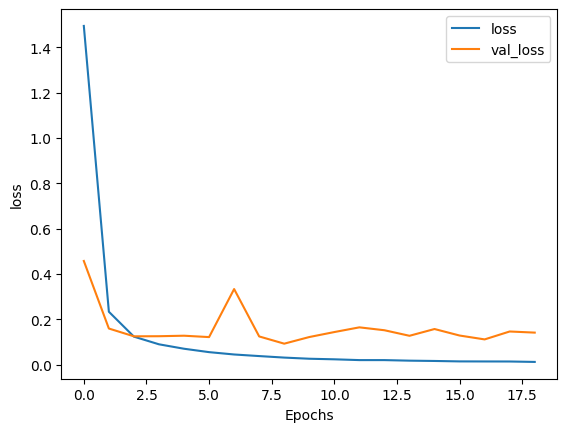

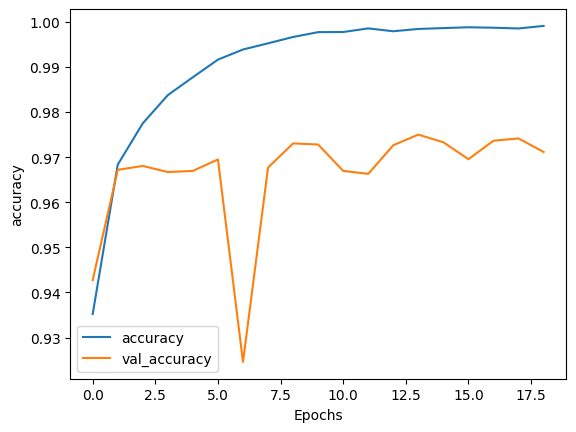

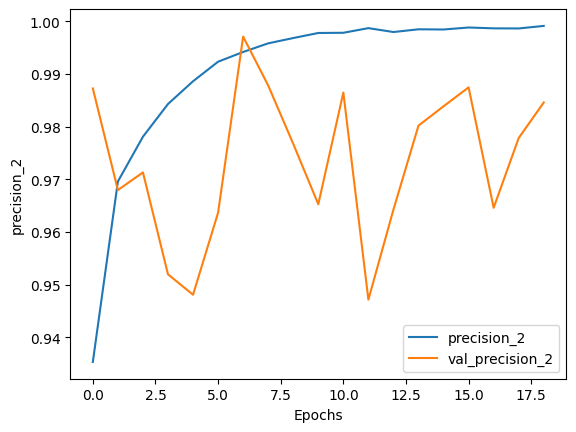

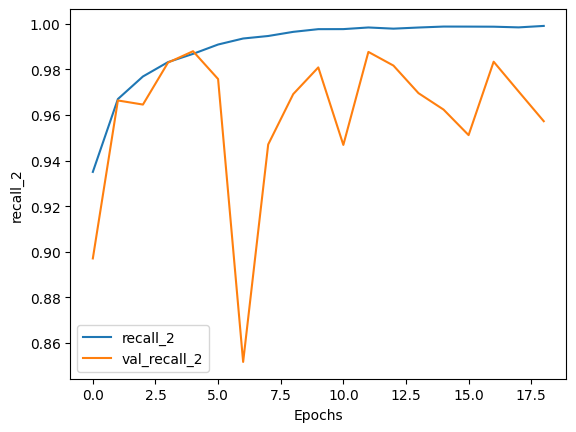

In [21]:
# Plot error rates and metric rates
plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')
plot_metrics(EfficientNet_model_history, 'precision_2')
plot_metrics(EfficientNet_model_history, 'recall_2')

In [22]:
# Save the EfficientNet model
EfficientNet_model.save("EfficientNet_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# MobileNet

In [23]:
# Building the Transfer Learning model using MobileNetV3
MobileNet_base_model = tf.keras.applications.MobileNetV3Small(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
MobileNet_base_model.trainable = True

# Create a new model on top of the MobileNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = MobileNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
MobileNet_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
MobileNet_model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 batch_normalization_3 (Bat  (None, 576)               2304      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 256)               147712    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                              

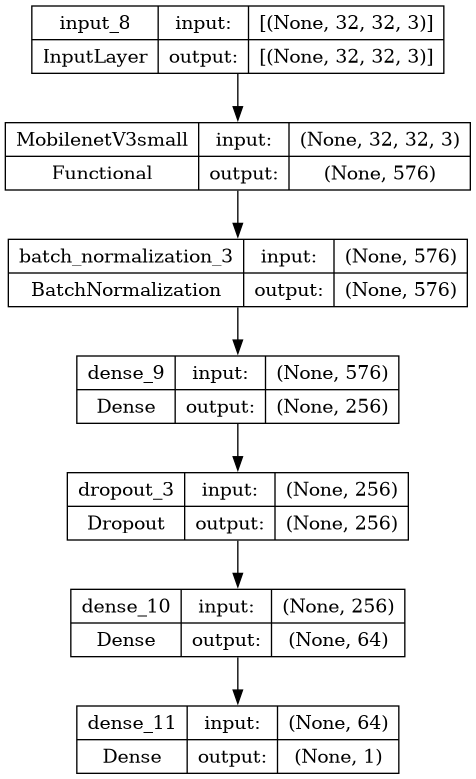

In [24]:
# Visualize the MobileNet model architecture
tf.keras.utils.plot_model(MobileNet_model, show_shapes = True, to_file = 'MobileNet_model.png')
Image('MobileNet_model.png')

In [25]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using MobileNet...")
MobileNet_model_history = MobileNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using MobileNet...
Epoch 1/100
196/196 [==============================] - 62s 156ms/step - loss: 1.0422 - accuracy: 0.7798 - precision_3: 0.8296 - recall_3: 0.7043 - val_loss: 0.6602 - val_accuracy: 0.7689 - val_precision_3: 0.6852 - val_recall_3: 0.9946
Epoch 2/100
196/196 [==============================] - 28s 137ms/step - loss: 0.2321 - accuracy: 0.9218 - precision_3: 0.9229 - recall_3: 0.9204 - val_loss: 0.2233 - val_accuracy: 0.9211 - val_precision_3: 0.8871 - val_recall_3: 0.9649
Epoch 3/100
196/196 [==============================] - 27s 132ms/step - loss: 0.1895 - accuracy: 0.9350 - precision_3: 0.9350 - recall_3: 0.9350 - val_loss: 0.2052 - val_accuracy: 0.9247 - val_precision_3: 0.9697 - val_recall_3: 0.8767
Epoch 4/100
196/196 [==============================] - 27s 134ms/step - loss: 0.1666 - accuracy: 0.9431 - precision_3: 0.9427 - recall_3: 0.9435 - val_loss: 0.1781 - val_accuracy: 0.9366 - val_precision_3: 0.9137 - val_recall_3: 0.9

In [26]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = MobileNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 93ms/step - loss: 0.1392 - accuracy: 0.9508 - precision_3: 0.9443 - recall_3: 0.9581
Val Loss: 0.1392
Val Accuracy: 0.9508
Val Precision: 0.9443
Val Recall: 0.9581


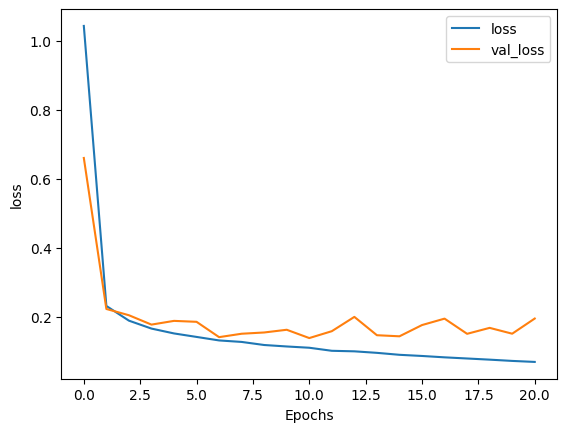

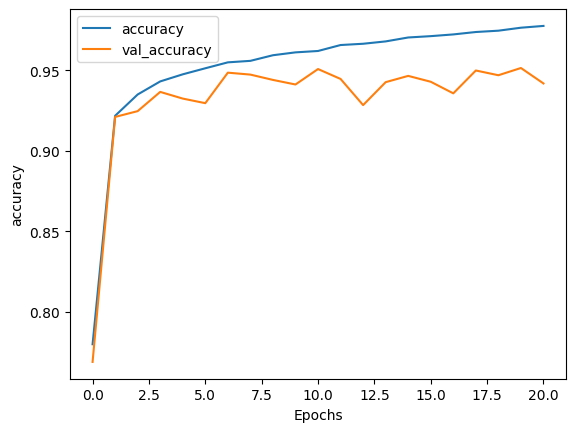

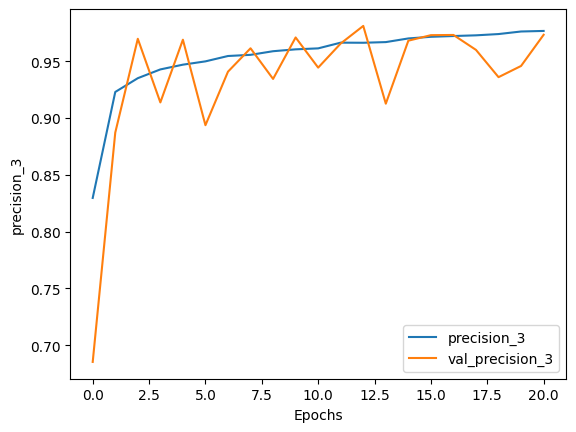

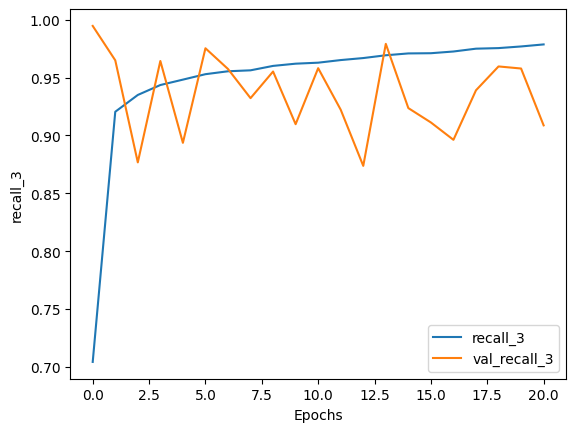

In [27]:
# Plot error rates and metric rates
plot_metrics(MobileNet_model_history, 'loss')
plot_metrics(MobileNet_model_history, 'accuracy')
plot_metrics(MobileNet_model_history, 'precision_3')
plot_metrics(MobileNet_model_history, 'recall_3')

In [28]:
# Save the MobileNet model
MobileNet_model.save("MobileNet_model.h5") 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The model with EfficientNet as the base is the clear winner with an accuracy of 97.29%; however, MobileNet is also a great option since its model size is significantly lower than EfficientNet's, with a minor decrease in performance.